In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install transformers tokenizers
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [ ]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

from typing import List
import logging
import copy
import os
import sys
import gc
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Empathy/t5_train_empathy.txt"
test_path = "drive/MyDrive/Individual Project/Data/Empathy/test.txt"
val_path = "drive/MyDrive/Individual Project/Data/Empathy/val.txt"

In [ ]:
labels = [ "no", "weak", "strong"]
label2int = dict(zip(labels, list(range(len(labels)))))

In [ ]:
#load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

!mkdir -p tokenizer

tokenizer.save_pretrained("tokenizer")

!ls tokenizer

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
class EmpathyClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            nn.Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

In [ ]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512): 

        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [ ]:
class EmpathyDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmpathyClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels))
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmpathyDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers=4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
    
    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)

In [ ]:
#chosen hyperparams:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=2, 
    seed=42
)
module = TrainingModule(hparams)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#train
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | EmpathyClassificationModel | 12

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
#save model (uncomment to save)

module.save_model('/content/RoBERTa_student_T5_teacher.pt')


In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

\
________________________________________________________________________________
              precision    recall  f1-score   support

          no     0.9655    0.7568    0.8485        37
        weak     0.6744    0.7436    0.7073        39
      strong     0.7436    0.8286    0.7838        35

    accuracy                         0.7748       111
   macro avg     0.7945    0.7763    0.7799       111
weighted avg     0.7933    0.7748    0.7785       111



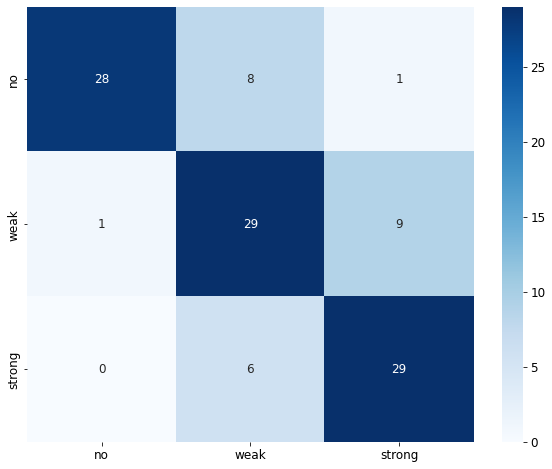

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
model = EmpathyClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels))
model.load_state_dict(torch.load('/content/RoBERTa_student_T5_teacher.pt'))


/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


<All keys matched successfully>

In [ ]:
import re

def get_empathy_score(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()

  t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
  t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
  t.enable_truncation(512)
  t.enable_padding(pad_id=t.token_to_id("<pad>"))
  tokenizer = t

  encoded = tokenizer.encode(text)
  sequence_padded = torch.tensor(encoded.ids).unsqueeze(0)
  attention_mask_padded = torch.tensor(encoded.attention_mask).unsqueeze(0)
   
  output = model((sequence_padded, attention_mask_padded))
  top_p, top_class = output.topk(1, dim=1)
  label = int(top_class[0][0])
  label_map = {v: k for k, v in label2int.items()}
  
  return label_map[label]

In [ ]:
get_empathy_score('I can feel your pain and would like to help you feel better. Could you tell me if anything recent triggered this feeling?')

'strong'